In [1]:
import os
import time
import random
import numpy as np
from matplotlib import cm
from datetime import datetime
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor

import active_learning_code_20220325

In [2]:
plot_size = (12, 6.75)  # The size of all the plots
x_d = 1 # Used to define the number of variables in input layer
y_d = 1 # Used for define the number of variables in output layer

number_of_range_points = 201
x_mini, x_maxi =  np.array(0), np.array(15)
obj_f = active_learning_code_20220325.function_generator(x_mini, x_maxi, dimension=x_d, random_seed=55)

x_range = np.linspace(x_mini, x_maxi, number_of_range_points)
all_true_y = obj_f(x_range)
max_distance_in_y = active_learning_code_20220325.max_distance(all_true_y)

number_of_training_points = 6
# Indices for the training points by number_of_training_points
train_indices = [j for j in range(len(x_range))
                 if j % (int((len(x_range)-1)/(number_of_training_points-1))) == 0]
print('train_indices', train_indices)

def plot_1D(plot_size, x_range, all_true_y, noised_all_y, max_allowed_pred_error,
            x_train, y_train, obj_f, random_seed, noise_level):
    plt.figure(figsize=plot_size)
    plt.plot(x_range, all_true_y, label='all_true')
    plt.plot(x_range, noised_all_y, linestyle='dashed', label='noised_all_true')
    plt.plot(x_range, noised_all_y+max_allowed_pred_error, linestyle=':', label='pred_upper_limit')
    plt.plot(x_range, noised_all_y-max_allowed_pred_error, linestyle=':', label='pred_lower_limit')
    plt.scatter(x_train, obj_f(x_train), label='noise_free_training_point')
    plt.scatter(x_train, y_train, s=30, c='r', label='noised_training_point')
    for i in range(len(x_train)):
        plt.annotate(str(i+1), xy=(x_train[i], y_train[i]), xytext=(x_train[i]+0.015, y_train[i]+0.015))
    plt.title('Random seed in {} and noise in {}%' .format(random_seed, 100*noise_level))
    plt.legend()
    plt.show()
    

train_indices [0, 40, 80, 120, 160, 200]


Random seed:  30 , noise portion:  0.05
x_train is: [ 0.  3.  6.  9. 12. 15.]
y_train is: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342]
The termination_mse_threshold is:  0.009173746363473553
The max_allowed_pred_error constrain is:  0.3317905308499365


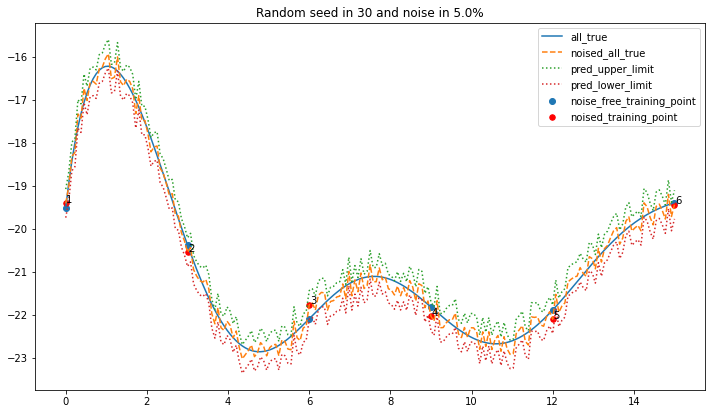

In [3]:
# Set the noise level and random seed to generate the training dataset
noise_level  = 0.05
random_seed =30
print("Random seed: ", random_seed, ', noise portion: ', noise_level)
noise_distance = noise_level * max_distance_in_y

current_dir = os.getcwd()
# Change the working folder relating to the noise level
working_folder = os.path.join(current_dir, 'Noise_level_'+ str(noise_level))
if not os.path.exists(working_folder):
    os.makedirs(working_folder)
os.chdir(working_folder)

# Generate the noised y and get the x_train and y_train as the training dataset
np.random.seed(random_seed)
noised_all_y = all_true_y + np.random.uniform(-1.0, 1.0, size=all_true_y.shape) * noise_distance
x_train, y_train = x_range[train_indices], noised_all_y[train_indices]

# Calculate the termination_mse_threshold and the maximum allowed prediction error
termination_mse_threshold = (1/12) * np.power(noise_level, 2) * np.power(max_distance_in_y, 2)
max_allowed_pred_error =  noise_level * max_distance_in_y

print('x_train is:', np.squeeze(x_train))
print('y_train is:', np.squeeze(y_train))
print('The termination_mse_threshold is: ', termination_mse_threshold)
print('The max_allowed_pred_error constrain is: ', max_allowed_pred_error)

# Plotting the function and the noised (noise free) training data points
plot_1D(plot_size, x_range, all_true_y, noised_all_y, max_allowed_pred_error,
        x_train, y_train, obj_f, random_seed, noise_level)

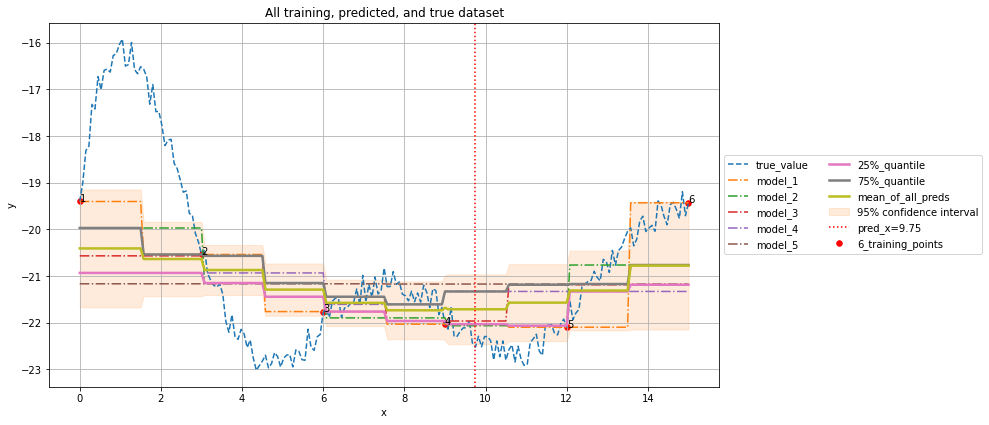

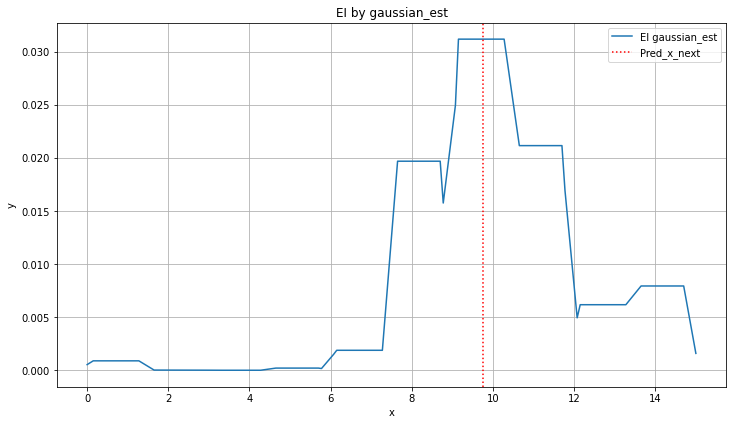

The predicted x_next=9.75 with EI of y in 0.03116724895295682.


[9.75]

In [4]:
show_plot = True # The policy of showing the plot in the user interface or not.

solver = active_learning_code_20220325.ActiveLearningSolver()
for i in range(5):    
    model, model_type, kargs  = solver.define_a_model(x_d=x_d, y_d=y_d, model_type=KNeighborsRegressor, n_neighbors=i+1, 
                                                      weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                                                      metric_params=None, n_jobs=None)
    solver.add_model_to_QBC(model, model_type, kargs)
    
solver.fit_models(x_train=x_train, y_train=y_train)

solver.predict_a_step_by_QBC(x_range, y_range=noised_all_y, pdf_type='Gaussian',
                              plot_size=(12, 6.7), show_plot=True, 
                              aqf_plot=True, threshold=0.01, epsilon=0.3)

Extended x_train: [ 0.    3.    6.    9.   12.   15.    9.75]
Extended y_train: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342 -22.37986986]
----------------------------------------------------------
The 2th prediction by QBC. 

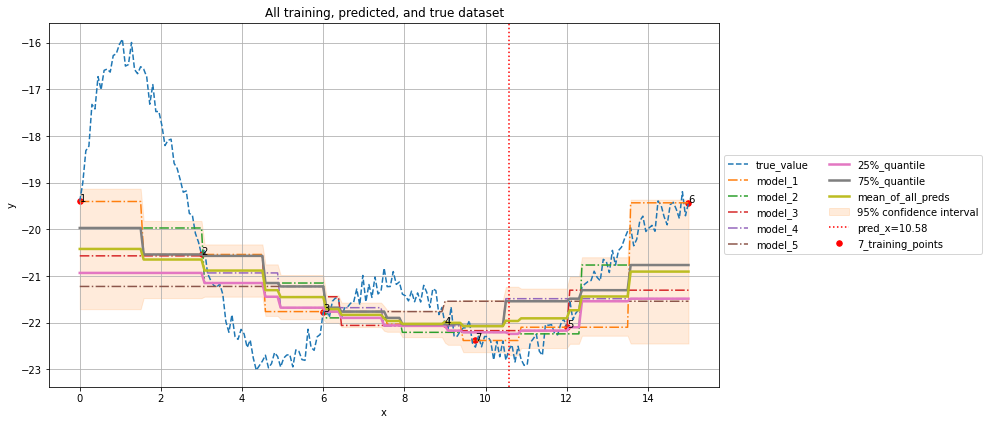

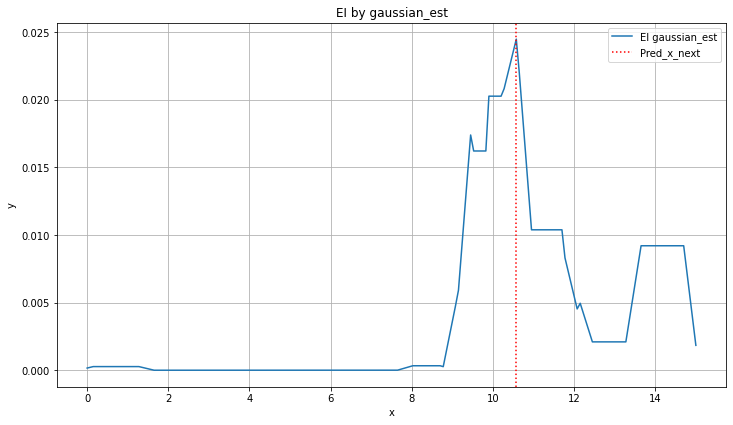

The predicted x_next=10.575 with EI of y in 0.0248367181878823.
Extended x_train: [ 0.     3.     6.     9.    12.    15.     9.75  10.575]
Extended y_train: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342 -22.37986986 -22.66719707]
----------------------------------------------------------
The 3th prediction by QBC. 

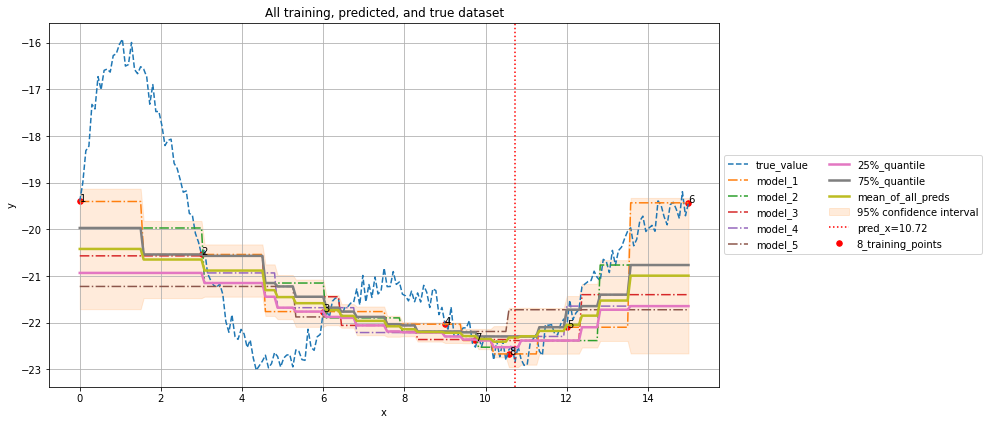

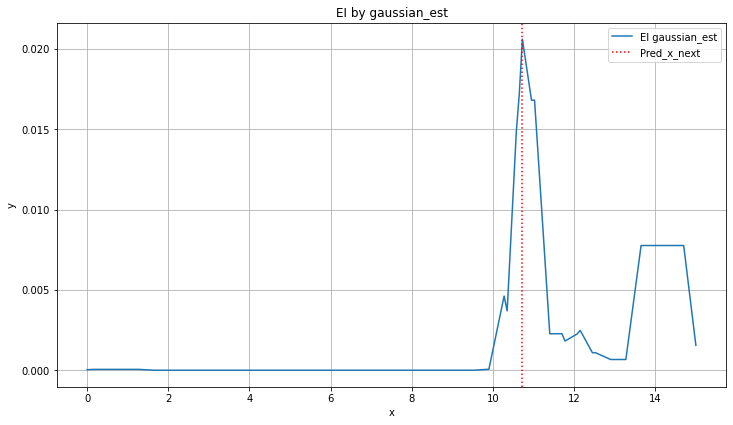

The predicted x_next=10.725 with EI of y in 0.023132168959823687.
Extended x_train: [ 0.     3.     6.     9.    12.    15.     9.75  10.575 10.725]
Extended y_train: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342 -22.37986986 -22.66719707 -22.66064385]
----------------------------------------------------------
The 4th prediction by QBC. 

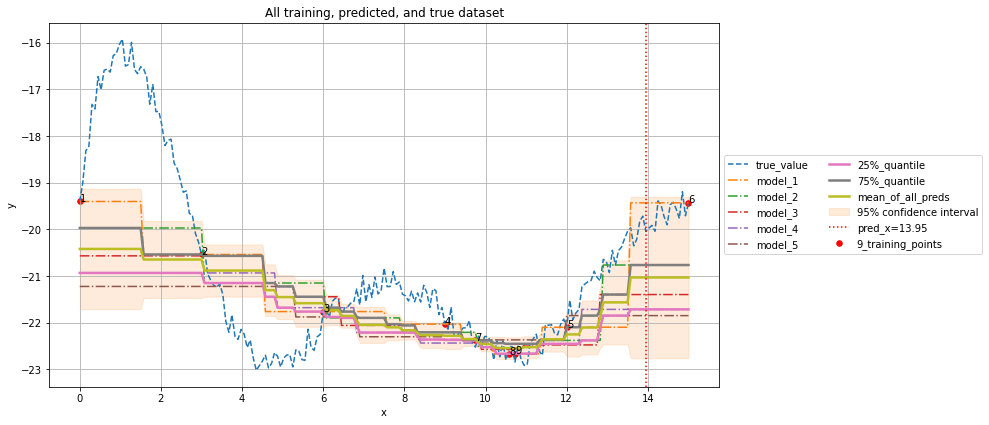

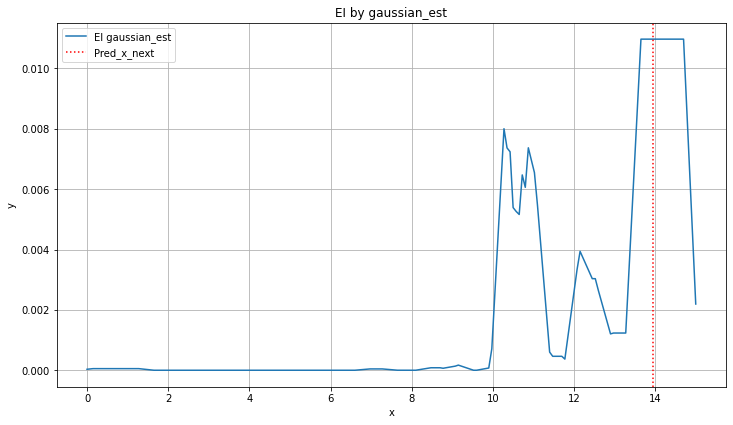

The predicted x_next=13.95 with EI of y in 0.010970799445584684.


[9.75, 10.575, 10.725, 13.95]

In [5]:
predict_n_steps_further = 3  # Control the number of prediction steps.
solver.predict_n_steps_by_QBC(true_y_next=False, n_step=predict_n_steps_further, orig_func=[all_true_y, noised_all_y],
                              x_range=x_range, pdf_type='Gaussian', plot_size=(12, 6.7), show_plot=show_plot,
                              aqf_plot=True, threshold=0.01, epsilon=0.6)

noise_distance 0.3317905308499365
----------------------------------------------------------
The 1st prediction by QBC. 

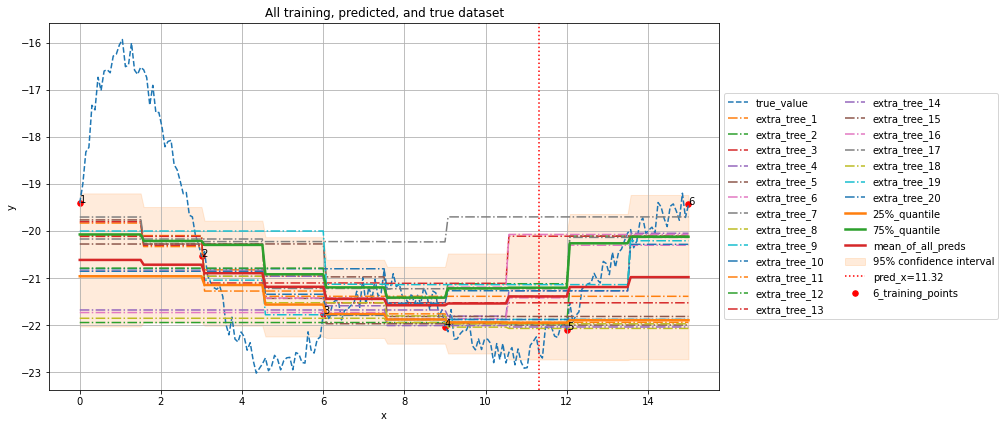

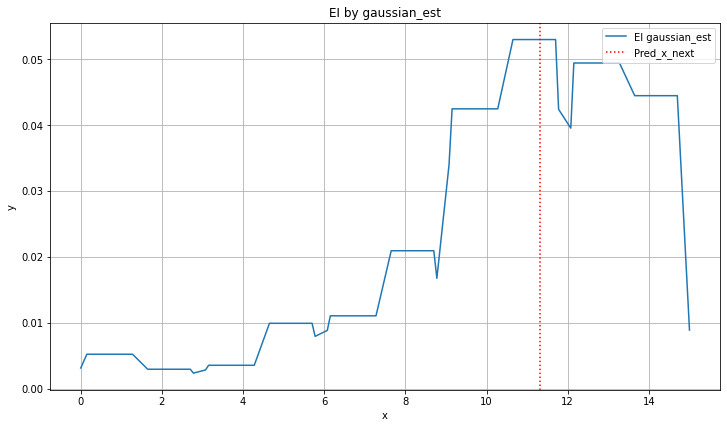

The predicted x_next=11.325 with EI of y in 0.05300788755032511.
Extended x_train: [ 0.     3.     6.     9.    12.    15.    11.325]
Extended y_train: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342 -22.61038944]
----------------------------------------------------------
The 2th prediction by QBC. 

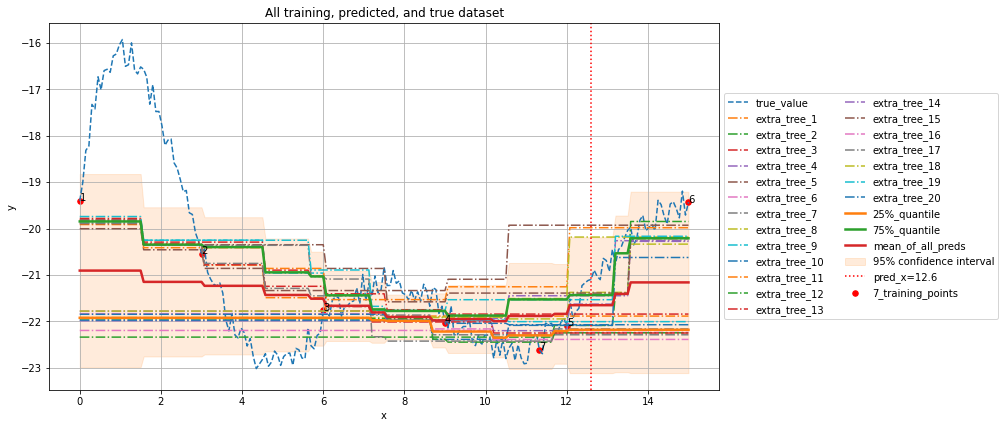

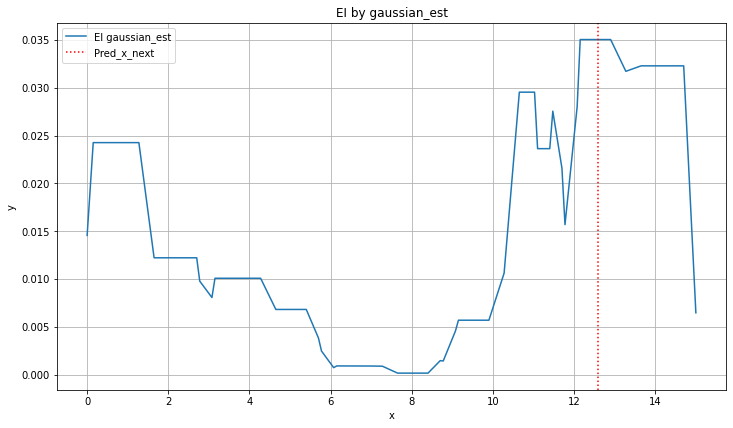

The predicted x_next=12.6 with EI of y in 0.0350542752472128.
Extended x_train: [ 0.     3.     6.     9.    12.    15.    11.325 12.6  ]
Extended y_train: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342 -22.61038944 -21.09488537]
----------------------------------------------------------
The 3th prediction by QBC. 

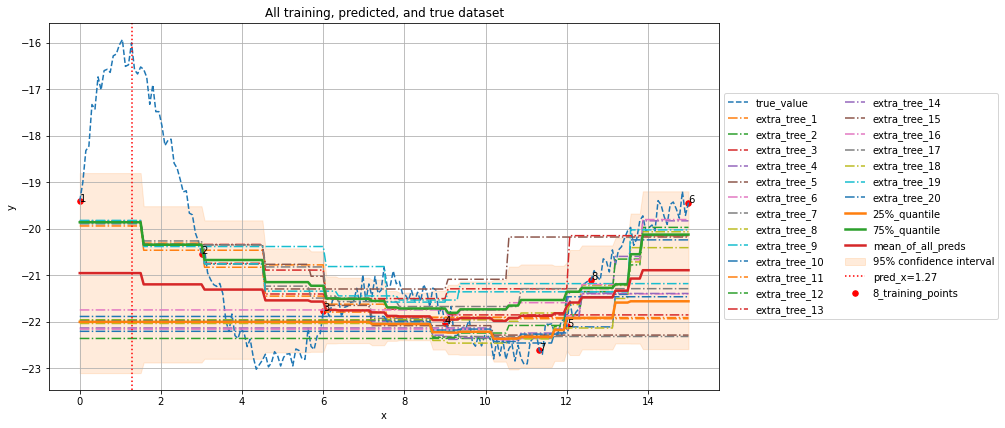

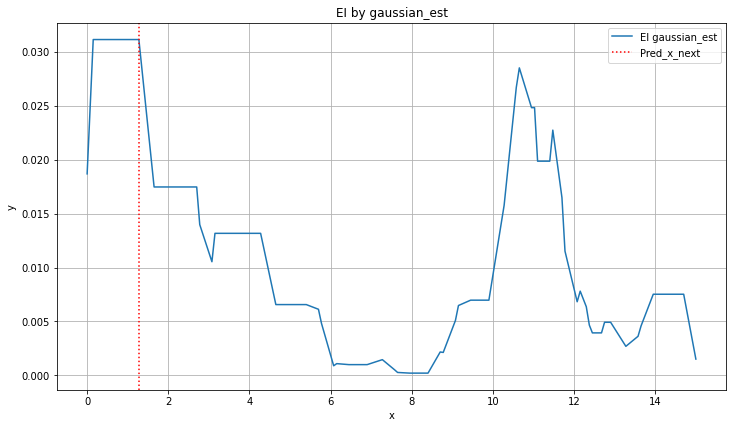

The predicted x_next=1.275 with EI of y in 0.0311576010594828.


[11.325, 12.6, 1.275]

In [6]:
predict_n_steps_further = 3  # Control the number of prediction steps.
show_plot = True # The policy of showing the plot in the user interface or not.
print('noise_distance', noise_distance)
solver = active_learning_code_20220325.ActiveLearningSolver()
model, model_type, kargs  = solver.define_a_model(x_d=x_d, y_d=y_d)
solver.fit_models(x_train=x_train, y_train=y_train, extra_tree_method='forest', tau=['mae', noise_distance])
solver.predict_n_steps_by_QBC(true_y_next=False, n_step=predict_n_steps_further, orig_func=noised_all_y, 
                              x_range=x_range, pdf_type='Gaussian', plot_size=plot_size, show_plot=show_plot,
                              aqf_plot=True, threshold=0.01, epsilon=0.6)

noise_distance 0.3317905308499365
----------------------------------------------------------
The 1st prediction by QBC. 

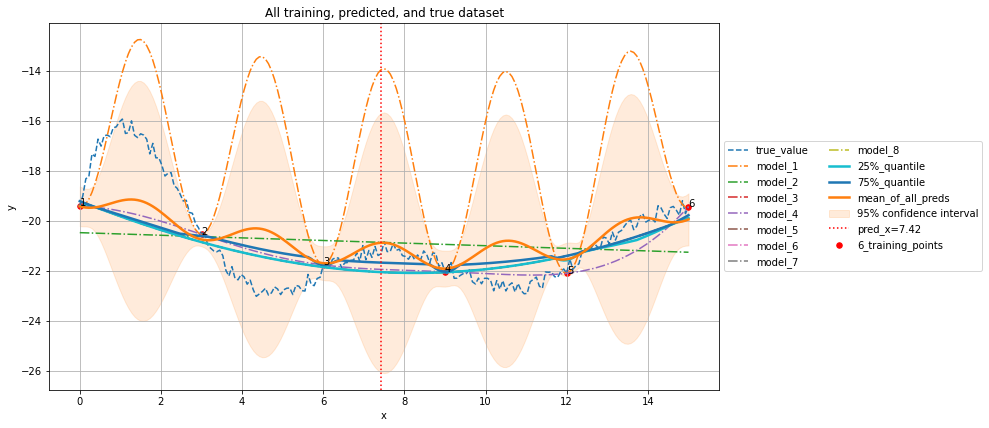

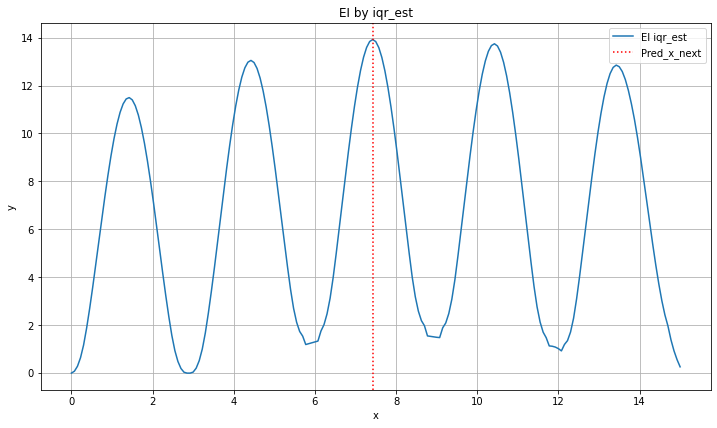

The predicted x_next=7.425 with EI of y in 14.087708213569975.
Extended x_train: [ 0.     3.     6.     9.    12.    15.     7.425]
Extended y_train: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342 -21.31786242]


C:\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 3162.2776601683795. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


----------------------------------------------------------
The 2th prediction by QBC. 

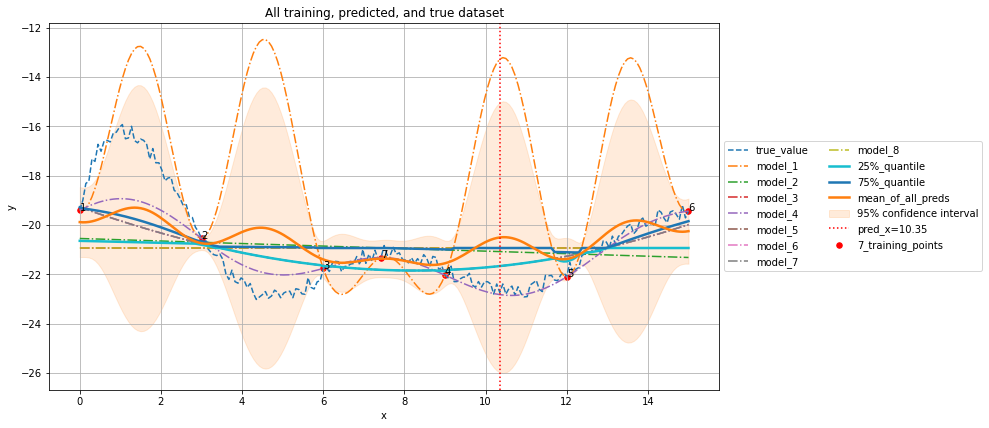

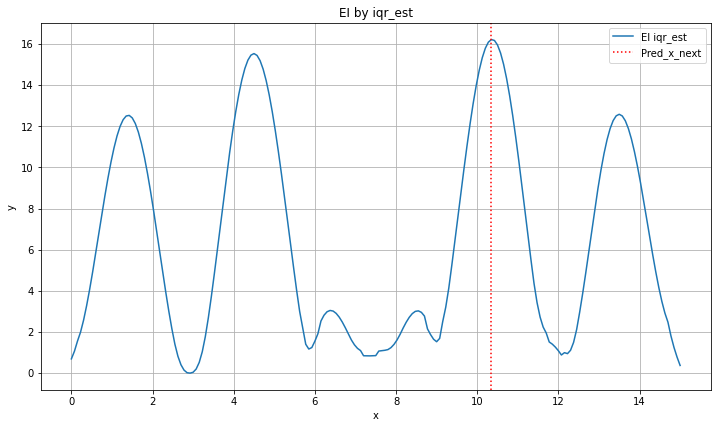

The predicted x_next=10.35 with EI of y in 16.38702753552119.
Extended x_train: [ 0.     3.     6.     9.    12.    15.     7.425 10.35 ]
Extended y_train: [-19.40375125 -20.53807734 -21.76100584 -22.0302973  -22.09597694
 -19.43213342 -21.31786242 -22.72810207]


C:\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 3162.2776601683795. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


----------------------------------------------------------
The 3th prediction by QBC. 

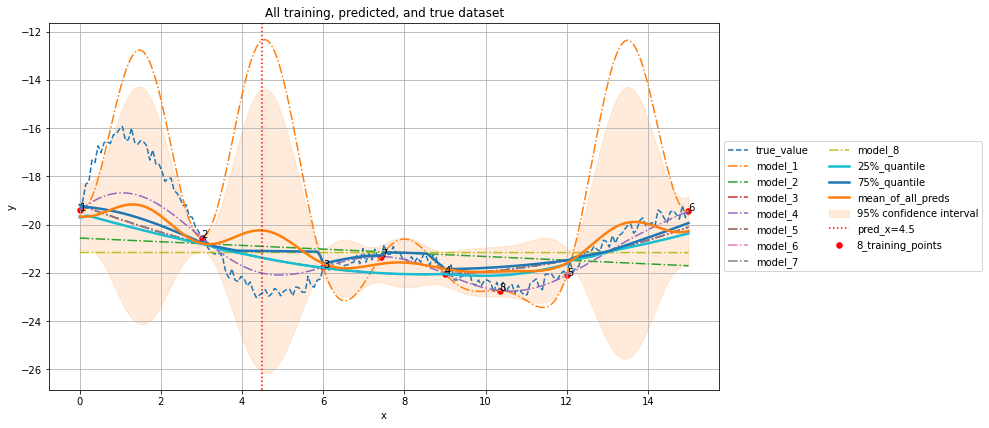

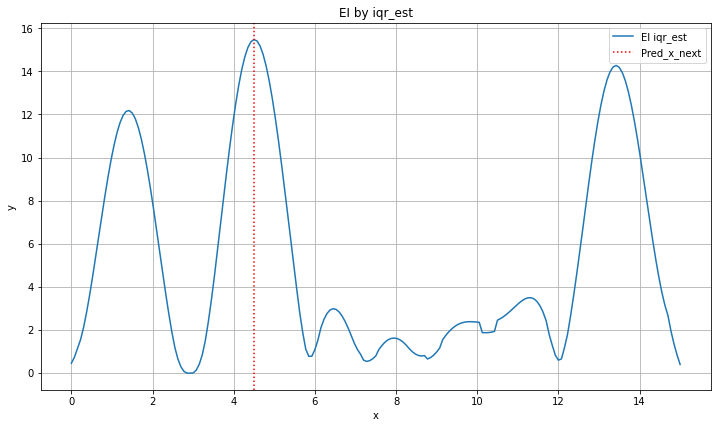

The predicted x_next=4.5 with EI of y in 15.64345897730998.


[7.425, 10.35, 4.5]

In [7]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, ConstantKernel

predict_n_steps_further = 3  # Control the number of prediction steps.
show_plot = True # The policy of showing the plot in the user interface or not.
print('noise_distance', noise_distance)
solver = active_learning_code_20220325.ActiveLearningSolver()

for c in range(8):
    kernel = 1.0 * RBF(length_scale=2*c+1, length_scale_bounds=(0.1**(c/2), 10**(c/2))) +\
                WhiteKernel(noise_level=c, noise_level_bounds=(0.1**(8-c), 10**(c/2)))
    if c == 0: kernel = None
    if c == 1: kernel = DotProduct() + WhiteKernel()
    if c == 2: kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)) +\
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-05, 100000.0))
    if c == 3: kernel = ConstantKernel() * RBF()

    model, model_type, kargs  = solver.define_a_model(x_d=x_d, y_d=y_d, model_type=GaussianProcessRegressor,
                                                      kernel=kernel, n_restarts_optimizer=25+c)
    solver.add_model_to_QBC(model, model_type, kargs)
    
solver.fit_models(x_train=x_train, y_train=y_train)
solver.predict_n_steps_by_QBC(true_y_next=False, n_step=predict_n_steps_further, orig_func=noised_all_y, 
                              x_range=x_range, pdf_type='iqr', plot_size=plot_size, show_plot=show_plot,
                              aqf_plot=True, threshold=0.01, epsilon=0.6)

No better solution is found after another 200 steps, the swarm stops moving.
The optimal found by the swarm is: x=[[4.58181908]], y=[[[15.64407991]]].
The optimal x found by PSO is [[4.58181908]] with EI in [[[15.64407991]]].


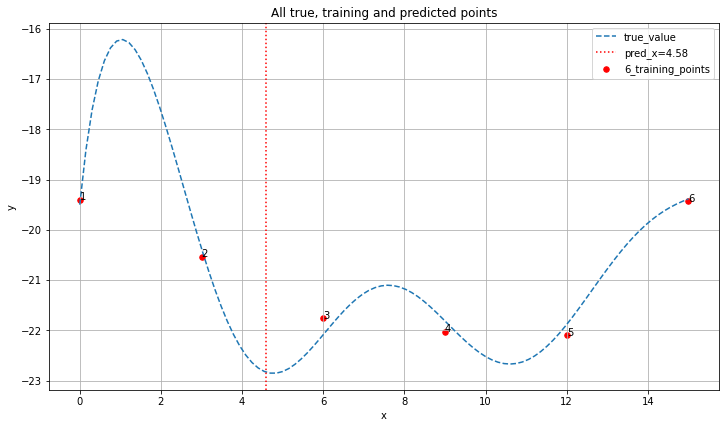

C:\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 3162.2776601683795. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


No better solution is found after another 200 steps, the swarm stops moving.
The optimal found by the swarm is: x=[[7.40156125]], y=[[[15.87766445]]].
The optimal x found by PSO is [[7.40156125]] with EI in [[[15.87766445]]].


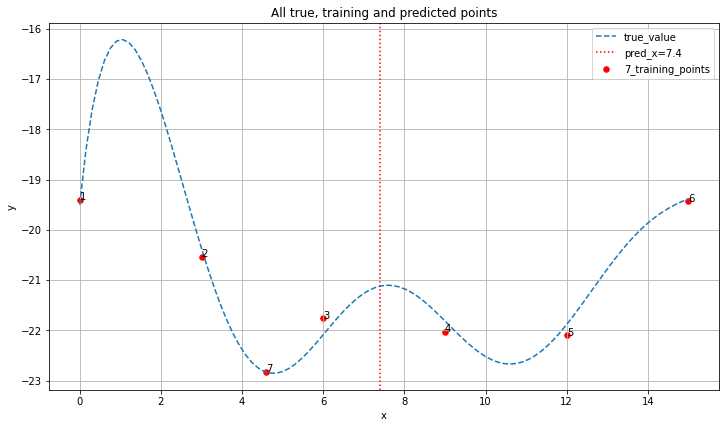

In [8]:
predict_n_steps_further = 2
search_space = np.array([[1, 0, 15]])
results_PSO = solver.predict_by_PSO(search_space, aqf='iqr', plot_size=plot_size,
                                    orig_func=obj_f, n_steps=predict_n_steps_further, show_plot=show_plot, 
                                    nr_particles=10, v_max=2.5, c1=0.3,
                                    c2=2.1, w=1.0, nr_steps=1000)

noise_distance 0.3317905308499365
Predict by Gaussian Process 2 times.
The predicted next x by Gaussian Process is [[10.8]] with the maximumExpected_Improvement in 0.33788883584824103.


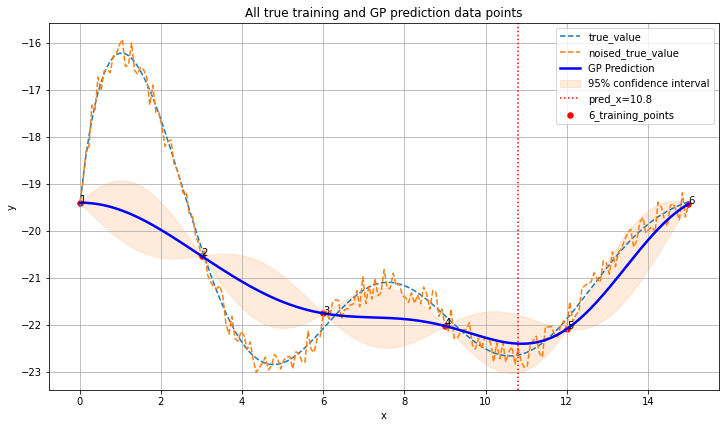

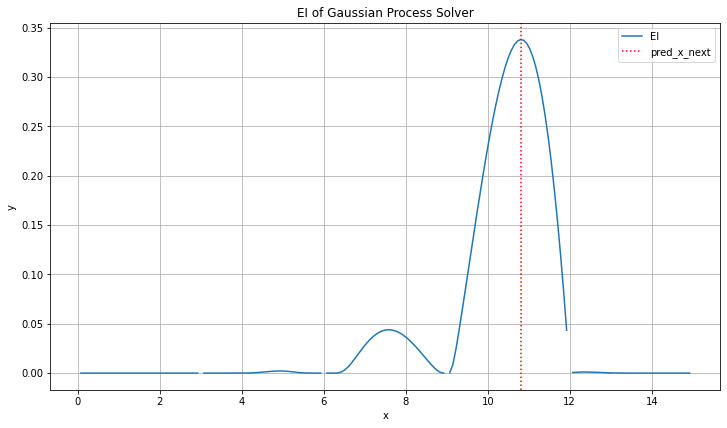

The predicted next x by Gaussian Process is [[10.725]] with the maximumExpected_Improvement in 0.005932420900180862.


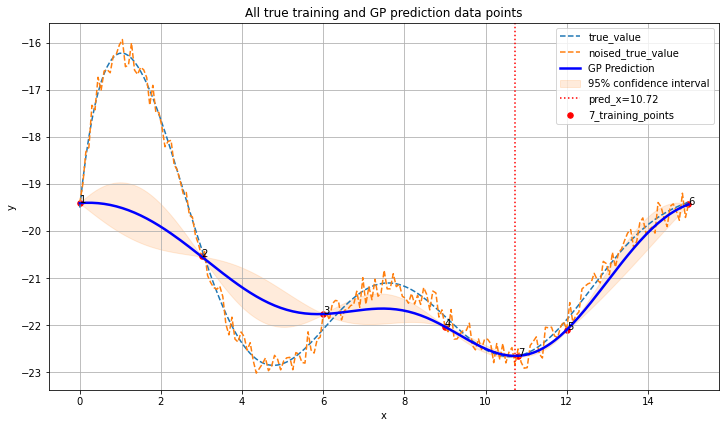

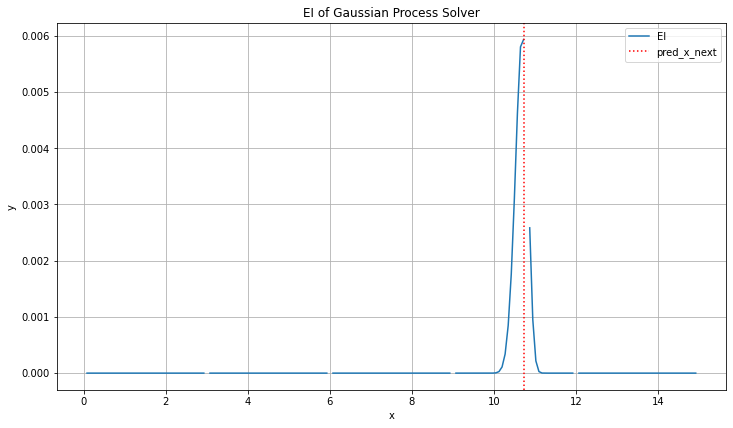

Parameters are saved at 20220404-095744-753
Predict_by_GP: [([[10.799999999999999]], 0.33788883584824103), ([[10.725]], 0.005932420900180862)]


In [10]:
predict_n_steps_further = 2
print('noise_distance', noise_distance)
solver = active_learning_code_20220325.ActiveLearningSolver()

print('Predict by Gaussian Process {} times.'.format(predict_n_steps_further))
GP = solver.predict_by_GP(x_train, y_train, x_range, n_step=predict_n_steps_further, aqf_plot=True,
                         plot_size=plot_size, show_plot=show_plot, y_true_in_x_range=[all_true_y, noised_all_y],
                         orig_func=obj_f, constant_value=1.0, constant_value_bounds=(noise_distance, 1000.0),
                         length_scale_bounds=(noise_distance, 1000.0), length_scale=1.0, optimizer='fmin_l_bfgs_b',
                         n_restarts_optimizer=30, alpha=0.0001, normalize_y=True)
print('Predict_by_GP:', GP)

alpha 0.009173746363473553
noise_distance 0.3317905308499365
The predicted next x by Gaussian Process is [[10.8]] with the maximumExpected_Improvement in 0.32906554685196054.


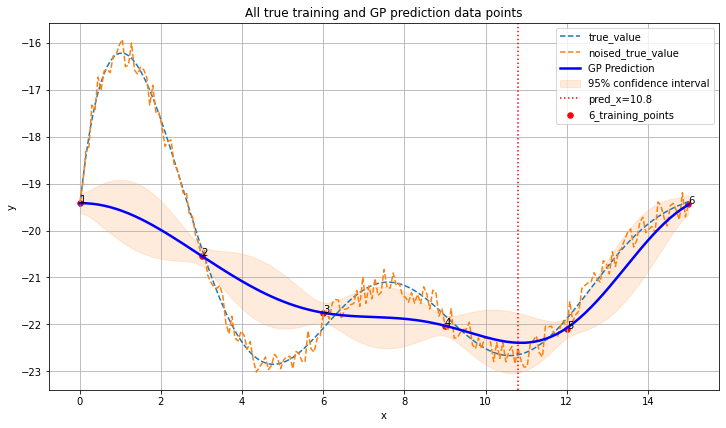

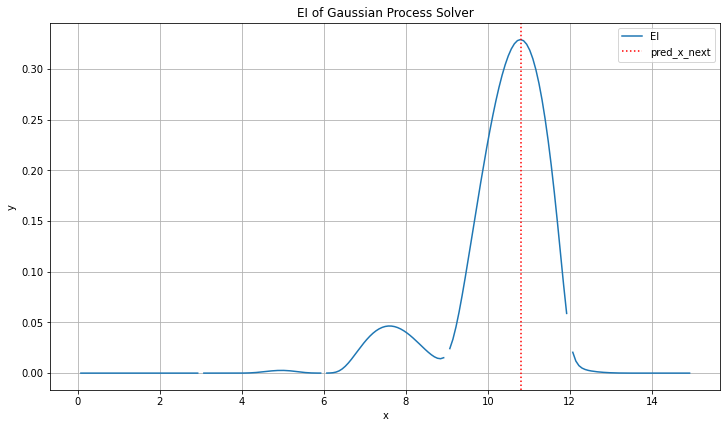

The predicted next x by Gaussian Process is [[10.725]] with the maximumExpected_Improvement in 0.027029127487106716.


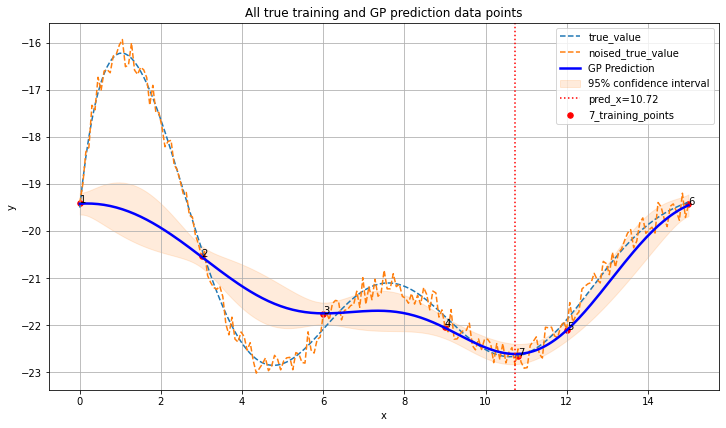

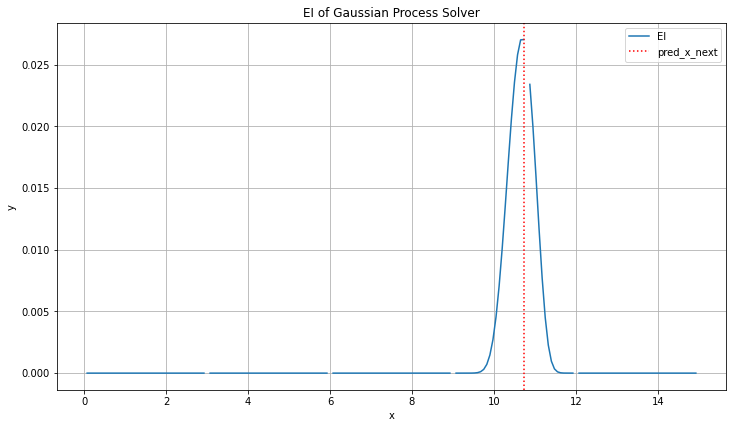

Parameters are saved at 20220404-095800-219


In [11]:
predict_n_steps_further = 2
show_plot = True
alpha = termination_mse_threshold
print('alpha', alpha)
print('noise_distance', noise_distance)
solver = active_learning_code_20220325.ActiveLearningSolver()
GP = solver.predict_by_GP(x_train, y_train, x_range, n_step=predict_n_steps_further, aqf_plot=True,
            plot_size=plot_size, show_plot=show_plot, y_true_in_x_range=[all_true_y, noised_all_y],
            orig_func=obj_f, constant_value=1.0, constant_value_bounds=(0.001*noise_distance, 10000.0),
            length_scale_bounds=(0.001*noise_distance, 10000.0), length_scale=1.0, optimizer='fmin_l_bfgs_b',
            n_restarts_optimizer=30, alpha=alpha, normalize_y=True)

The true y_min is -22.851476936292144, but the accepted min values (y_min + noise_distance) is -22.519686405442208.
There are 35 accepted minimum points over x_range.
Gaussian_Process_Solver predict 2 steps, and there are 2 predictions of x_next within the accepted minimum range.
Step_1 is the first time of the solver having x_next within the accepted minimum range.


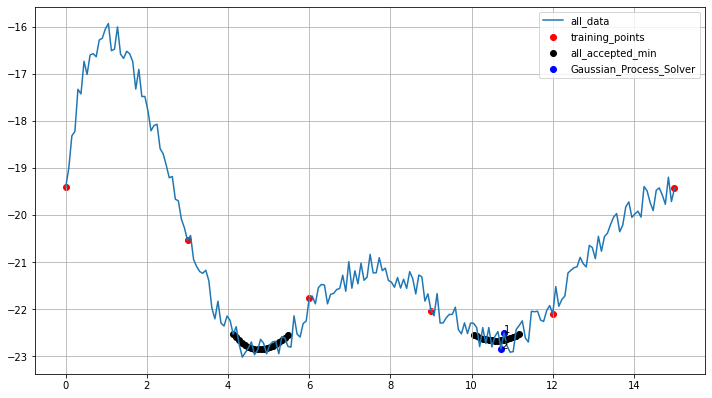

In [13]:
message = solver.result_analysis(x_range, noised_all_y, obj_f, x_train, y_train, figsize=plot_size,
                                 show_plot=show_plot, noise_distance=noise_distance)